# Predicting Remaining Useful Life (advanced)
<p style="margin:30px">
    <img style="display:inline; margin-right:50px" width=50% src="https://www.featuretools.com/wp-content/uploads/2017/12/FeatureLabs-Logo-Tangerine-800.png" alt="Featuretools" />
    <img style="display:inline" width=15% src="https://upload.wikimedia.org/wikipedia/commons/e/e5/NASA_logo.svg" alt="NASA" />
</p>

This notebook has a more advanced workflow than [the other notebook](Simple%20Featuretools%20RUL%20Demo.ipynb) for predicting Remaining Useful Life (RUL). If you are a new to either this dataset or Featuretools, I would recommend reading the other notebook first.

## Highlights
* Demonstrate how novel entityset structures improve predictive accuracy
* Use TSFresh Primitives from a featuretools [addon](https://featuretools.alteryx.com/en/stable/install.html#add-ons)
* Improve Mean Absolute Error by tuning hyper parameters with [BTB](https://github.com/HDI-Project/BTB)


# Step 1: Load Data
We load in the train data using the same function we used in the previous notebook:

In [1]:
import composeml as cp
import numpy as np
import pandas as pd
import featuretools as ft
import utils
import os

from tqdm import tqdm
from sklearn.cluster import KMeans

import warnings
warnings.simplefilter('ignore')

In [2]:
data_path = 'data/train_FD004.txt'
data = utils.load_data(data_path)
data.head()

Loaded data with:
61249 Recordings
249 Engines
21 Sensor Measurements
3 Operational Settings


,engine_no,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,index,time
index,,,,,,,,,,,,,,,,,,,,,
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,0,2000-01-01 00:00:00
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,1,2000-01-01 00:10:00
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,2,2000-01-01 00:20:00
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,3,2000-01-01 00:30:00
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,4,2000-01-01 00:40:00


We also make cutoff times by using [Compose](https://compose.alteryx.com) for generating labels on engines that reach at least 100 cycles. For each engine, we generate 10 labels that are spaced 10 cycles apart.

In [3]:
def remaining_useful_life(df):
    return len(df) - 1

lm = cp.LabelMaker(
    target_dataframe_name='engine_no',
    time_index='time',
    labeling_function=remaining_useful_life,
)

label_times = lm.search(
    data.sort_values('time'),
    num_examples_per_instance=10,
    minimum_data=100,
    gap=10,
    verbose=True,
)

label_times.head()

Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|█████████████████████████████████████████████████████████████| engine_no: 2490/2490 


,engine_no,time,remaining_useful_life
0,1,2000-01-01 16:40:00,220
1,1,2000-01-01 18:20:00,210
2,1,2000-01-01 20:00:00,200
3,1,2000-01-01 21:40:00,190
4,1,2000-01-01 23:20:00,180


We're going to make 5 sets of cutoff times to use for cross validation by random sampling the labels times we created previously.

In [4]:
splits = 5
cutoff_time_list = []

for i in range(splits):
    sample = label_times.sample(n=249, random_state=i)
    sample.sort_index(inplace=True)
    cutoff_time_list.append(sample)

cutoff_time_list[0].head()

,engine_no,time,remaining_useful_life
1,1,2000-01-01 18:20:00,210
9,1,2000-01-02 07:40:00,130
10,2,2000-01-03 22:10:00,198
14,2,2000-01-04 04:50:00,158
27,3,2000-01-06 11:40:00,136


We're going to do something fancy for our entityset. The values for `operational_setting` 1-3 are continuous but create an implicit relation between different engines. If two engines have a similar `operational_setting`, it could indicate that we should expect the sensor measurements to mean similar things. We make clusters of those settings using [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) from scikit-learn and make a new dataframe from the clusters.

In [5]:
nclusters = 50

def make_entityset(data, nclusters, kmeans=None):
    X = data[[
        'operational_setting_1',
        'operational_setting_2',
        'operational_setting_3',
    ]]

    if kmeans is None:
        kmeans = KMeans(n_clusters=nclusters).fit(X)

    data['settings_clusters'] = kmeans.predict(X)

    es = ft.EntitySet('Dataset')

    es.add_dataframe(
        dataframe=data,
        dataframe_name='recordings',
        index='index',
        time_index='time',
    )

    es.normalize_dataframe(
        base_dataframe_name='recordings',
        new_dataframe_name='engines',
        index='engine_no',
    )

    es.normalize_dataframe(
        base_dataframe_name='recordings',
        new_dataframe_name='settings_clusters',
        index='settings_clusters',
    )

    return es, kmeans


es, kmeans = make_entityset(data, nclusters)
es

Entityset: Dataset
  DataFrames:
    recordings [Rows: 61249, Columns: 29]
    engines [Rows: 249, Columns: 2]
    settings_clusters [Rows: 50, Columns: 2]
  Relationships:
    recordings.engine_no -> engines.engine_no
    recordings.settings_clusters -> settings_clusters.settings_clusters

## Visualize EntitySet

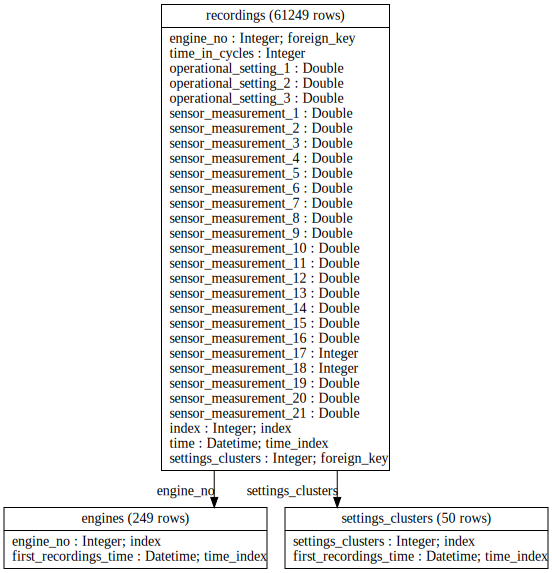

In [6]:
es.plot()

# Step 2: DFS and Creating a Model
In addition to changing our `EntitySet` structure, we're also going to use the [Complexity](http://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html#tsfresh.feature_extraction.feature_calculators.cid_ce) time series primitive from the featuretools [addon](https://featuretools.alteryx.com/en/stable/install.html#add-ons) of ready-to-use TSFresh Primitives.

Just like in the previous notebook, we will be using [EvalML](https://evalml.alteryx.com/en/stable/)

<p align="center">
<img width=50% src="https://evalml-web-images.s3.amazonaws.com/evalml_horizontal.svg" alt="Featuretools" />
</p>


In [7]:
from featuretools.tsfresh import CidCe

fm, features = ft.dfs(
    entityset=es,
    target_dataframe_name='engines',
    agg_primitives=['last', 'max', CidCe(normalize=False)],
    trans_primitives=[],
    chunk_size=.26,
    cutoff_time=cutoff_time_list[0],
    max_depth=3,
    verbose=True,
)

fm.to_csv('advanced_fm.csv')
fm.head()

Built 304 features
Elapsed: 01:25 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████


,"CID_CE(recordings.operational_setting_1, normalize=False)","CID_CE(recordings.operational_setting_2, normalize=False)","CID_CE(recordings.operational_setting_3, normalize=False)","CID_CE(recordings.sensor_measurement_1, normalize=False)","CID_CE(recordings.sensor_measurement_10, normalize=False)","CID_CE(recordings.sensor_measurement_11, normalize=False)","CID_CE(recordings.sensor_measurement_12, normalize=False)","CID_CE(recordings.sensor_measurement_13, normalize=False)","CID_CE(recordings.sensor_measurement_14, normalize=False)","CID_CE(recordings.sensor_measurement_15, normalize=False)",...,MAX(recordings.settings_clusters.MAX(recordings.sensor_measurement_21)),MAX(recordings.settings_clusters.MAX(recordings.sensor_measurement_3)),MAX(recordings.settings_clusters.MAX(recordings.sensor_measurement_4)),MAX(recordings.settings_clusters.MAX(recordings.sensor_measurement_5)),MAX(recordings.settings_clusters.MAX(recordings.sensor_measurement_6)),MAX(recordings.settings_clusters.MAX(recordings.sensor_measurement_7)),MAX(recordings.settings_clusters.MAX(recordings.sensor_measurement_8)),MAX(recordings.settings_clusters.MAX(recordings.sensor_measurement_9)),MAX(recordings.settings_clusters.MAX(recordings.time_in_cycles)),remaining_useful_life
engine_no,,,,,,,,,,,,,,,,,,,,,
1,208.777576,4.355841,211.660105,380.627959,1.792150,46.543688,1939.238240,1903.468066,1188.077642,10.661766,...,23.4578,1585.87,1404.99,14.62,21.59,553.15,2387.96,9053.86,111.0,210
1,269.413940,5.621277,282.842712,487.954763,2.392969,61.084289,2503.466467,2543.782289,1626.735462,14.498524,...,23.5729,1588.39,1404.99,14.62,21.59,554.23,2388.01,9055.13,191.0,130
2,199.764962,4.194227,195.959179,353.967679,1.737872,43.901649,1862.523931,1762.763195,1164.156379,10.303977,...,23.8649,1603.28,1422.53,14.62,21.61,567.07,2388.50,9114.84,321.0,198
2,230.523809,4.792752,240.000000,410.530161,2.001300,52.038703,2141.370941,2158.928528,1394.027359,12.292916,...,23.8649,1603.28,1422.53,14.62,21.61,567.07,2388.50,9114.84,321.0,158
3,271.826093,5.854931,293.938769,472.270085,2.475318,64.716036,2576.388154,2643.922171,1737.037013,15.251866,...,23.8649,1603.28,1434.23,14.62,21.61,567.07,2388.50,9114.84,321.0,136


We build 4 more feature matrices with the same feature set but different cutoff times. That lets us test the pipeline multiple times before using it on test data.

In [8]:
fm_list = [fm]

for i in tqdm(range(1, splits)):
    es = make_entityset(data, nclusters, kmeans=kmeans)[0]
    fm = ft.calculate_feature_matrix(
        entityset=es,
        features=features,
        chunk_size=.26,
        cutoff_time=cutoff_time_list[i],
    )
    fm_list.append(fm)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [05:27<00:00, 81.80s/it]


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import evalml
from evalml import AutoMLSearch

In [10]:
def pipeline_for_test(fm_list, hyperparams=None, do_selection=False):
    scores = []
    regs = []
    selectors = []

    hyperparams = hyperparams or {
        'n_estimators': 100,
        'max_feats': 50,
        'nfeats': 50,
    }

    for fm in fm_list:
        X = fm.copy().fillna(0)
        y = X.pop('remaining_useful_life')

        n_estimators = int(hyperparams['n_estimators'])
        max_features = int(hyperparams['max_feats'])
        max_features = min(max_features, int(hyperparams['nfeats']))

        X_train, X_test, y_train, y_test = train_test_split(X, y)
        
        automl = AutoMLSearch(X_train=X_train,
                              y_train=y_train,
                              problem_type="regression",
                              objective="mae",
                              max_batches=3,
                              max_iterations=20)
        automl.search()


        pipeline = automl.best_pipeline
        pipeline.fit(X_train, y_train)

        preds = pipeline.predict(X_test)
        mae = mean_absolute_error(preds, y_test)
        scores.append(mae)

    return scores, pipeline, selectors


scores, pipeline, selectors = pipeline_for_test(fm_list)
print([float('{:.1f}'.format(score)) for score in scores])

mean, std = np.mean(scores), np.std(scores)
info = 'Average MAE: {:.1f}, Std: {:.2f}\n'
print(info.format(mean, std))

print(pipeline.feature_importance[0:10])

[28.7, 35.8, 31.6, 40.6, 32.3]
Average MAE: 33.8, Std: 4.12

                                             feature  importance
0  MAX(recordings.settings_clusters.LAST(recordin...    0.404646
1              MAX(recordings.sensor_measurement_11)    0.050412
2              MAX(recordings.sensor_measurement_20)    0.031112
3               MAX(recordings.sensor_measurement_2)    0.027166
4  MAX(recordings.settings_clusters.LAST(recordin...    0.026602
5  MAX(recordings.settings_clusters.LAST(recordin...    0.020942
6  LAST(recordings.settings_clusters.LAST(recordi...    0.020545
7              MAX(recordings.sensor_measurement_15)    0.019818
8              MAX(recordings.sensor_measurement_13)    0.019034
9             LAST(recordings.sensor_measurement_13)    0.017813


In [11]:
data_test = utils.load_data('data/test_FD004.txt')

es_test, _ = make_entityset(
    data_test,
    nclusters,
    kmeans=kmeans,
)

fm_test = ft.calculate_feature_matrix(
    entityset=es_test,
    features=features,
    verbose=True,
    chunk_size=.26,
)

X = fm_test.copy().fillna(0)

y = pd.read_csv(
    'data/RUL_FD004.txt',
    sep=' ',
    header=None,
    names=['remaining_useful_life'],
    index_col=False,
)

preds = pipeline.predict(X)
mae = mean_absolute_error(preds, y)
print('Mean Abs Error: {:.2f}'.format(mae))

Loaded data with:
41214 Recordings
248 Engines
21 Sensor Measurements
3 Operational Settings
Elapsed: 00:01 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████
Mean Abs Error: 36.79


# Step 3: Hyperparameter Tuning
you are in luck! With evalML, the hyperparameter tuning is done for you! On the back end, we perform a Bayesian Search algorithm to identify the best parameters to use in every model tested

<p align="center">
<img width=50% src="https://alteryx-open-source-images.s3.amazonaws.com/OpenSource_Logo-01.jpg" alt="ayx_os" />
</p>

Featuretools was created by the developers at [Alteryx](https://www.alteryx.com). If building impactful data science pipelines is important to you or your business, please [get in touch](https://www.alteryx.com/contact-us/).